## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

### План решения:
##### Часть 1. Подготовка данных:
* [Подготовка данных]((#the_destination)) Загрузим датасет с атрибутами парсинга даты, даты будем использовать в качестве индекса нашей таблицы. Если индекс не монотонен, то отсортируем индексы с заменой в исходной таблице. Проверим таблицу на наличие дубликатов и пропущенные значения. Выполним ресемплирование данных по одному часу.  
* [Анализ]((#2nd_chap)) Посмотрим график ряда, разберем тренды и сезонность данных.  
* [Анализ результатов]((#3rd_chap)) Напишем функцию расчета rmse и используем её для создания собственного скорера. Создадим новый класс, создающий признаки для последующего гридсёрча. Поделим данные на обучающую и тестовую выборки, выберем наилучшую модель с помощью гридсёрча. 

<a id='the_destination'></a>
# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from collections import defaultdict
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

In [2]:
if not taxi.index.is_monotonic:
    taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()


In [3]:
taxi.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [4]:
taxi.shape

(4416, 1)

In [5]:
taxi.isna().sum()

num_orders    0
dtype: int64

In [6]:
taxi.index.min(), taxi.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:00:00'))

<a id='2nd_chap'></a>
# 2. Анализ

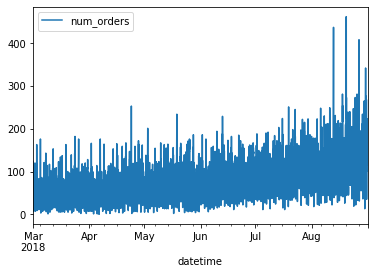

In [7]:
taxi.plot()

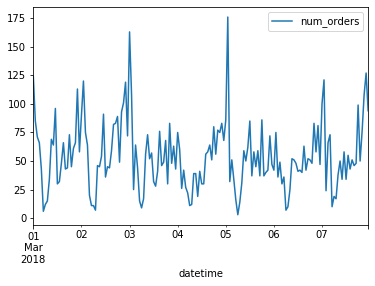

In [8]:
taxi.head(24*7).plot()

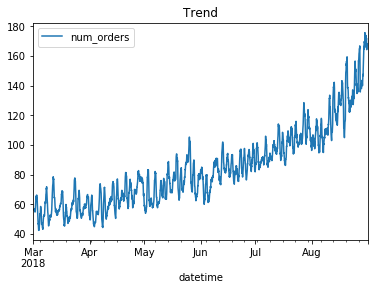

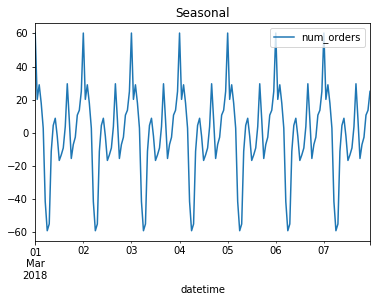

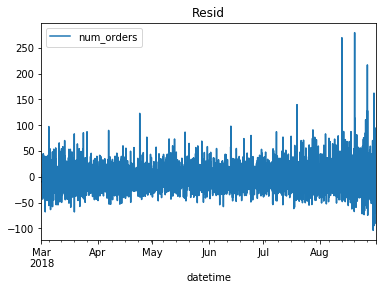

In [9]:
decomposed = seasonal_decompose(taxi)
decomposed.trend.plot(title='Trend')
decomposed.seasonal.head(24*7).plot(title='Seasonal')
decomposed.resid.plot(title='Resid')

#### Вывод:  
* Ярко выражен тренд на увеличение количества заказов;  
* Прослеживается сезонность в рамках суток.

<a id='3кd_chap'></a>

# 3. Обучение

Напишем свою метрику качества по RMSE

In [10]:
def root_mse(target_true, target_predicted):
    return np.sqrt(mean_squared_error(target_true, target_predicted))

In [11]:
rmse = make_scorer(root_mse, greater_is_better=False)

Создадим свой класс дляя создания признаков, для последующего гридсёрча.

In [12]:
class FeatureMaker(BaseEstimator, TransformerMixin):
    def __init__(self, max_lag, rolling_mean_size, target, year=True, month=True, day=True, dayofweek=True, hour=True, fillna=True):
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size
        self.year = year
        self.month = month
        self.day = day
        self.dayofweek = dayofweek
        self.hour=hour
        self.fillna = fillna
        self.target =target
        
        self.lag_ = defaultdict()
    
    
# Перезапишем методы reset fit и transform класса TransformerMixin
    def _reset(self):        
        if hasattr(self, 'X_'):               
            del self.X_
            del self.y_
            
           
    def fit(self, X, y=None):
        self._reset()           
        
        
        self.X_ = X.drop(columns=self.target)
        self.y_ = X[self.target]
        
        return self
    
    def transform(self, X):
        
        tmp = X.copy()
        
        for l in range(self.max_lag):
            tmp['lag_'+str(l)] = tmp[self.target].shift(l+1)
            
        tmp['rolling_mean'] = tmp[self.target].shift().rolling(self.rolling_mean_size).mean()
        
        if self.year:
            tmp['year'] = X.index.year
        if self.month:
            tmp['month'] = X.index.month           
        if self.day:
            tmp['day'] = X.index.day
        if self.dayofweek:
            tmp['dayofweek'] = X.index.dayofweek
        if self.hour:
            tmp['hour'] = X.index.hour

        
        # dropna
        indexes_to_drop = tmp.index[tmp.isnull().any(1)].tolist()
        
#         self.y_.drop(indexes_to_drop, inplace=True)
#         tmp.dropna(inplace=True)
        tmp.fillna(method='bfill', inplace=True)
        
        #drop target
        tmp = tmp.drop(columns=self.target)
        return tmp
    

In [13]:
# Проверим, что методы нашего нового класса работают, так как ожидается
maker = FeatureMaker(max_lag=4, rolling_mean_size=3, target='num_orders', year=False)

X = taxi
y = taxi['num_orders']

maker.fit_transform(X).head(2)

,lag_0,lag_1,lag_2,lag_3,rolling_mean,month,day,dayofweek,hour
datetime,,,,,,,,,
2018-03-01 00:00:00,124.0,124.0,124.0,124.0,93.333333,3,1,3,0
2018-03-01 01:00:00,124.0,124.0,124.0,124.0,93.333333,3,1,3,1


In [14]:
### код ревьюера
### исходная матрица
X

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [15]:
### код ревьюера
### матрица признаков
X_new = maker.fit_transform(X)
X_new

,lag_0,lag_1,lag_2,lag_3,rolling_mean,month,day,dayofweek,hour
datetime,,,,,,,,,
2018-03-01 00:00:00,124.0,124.0,124.0,124.0,93.333333,3,1,3,0
2018-03-01 01:00:00,124.0,124.0,124.0,124.0,93.333333,3,1,3,1
2018-03-01 02:00:00,85.0,124.0,124.0,124.0,93.333333,3,1,3,2
2018-03-01 03:00:00,71.0,85.0,124.0,124.0,93.333333,3,1,3,3
2018-03-01 04:00:00,66.0,71.0,85.0,124.0,74.000000,3,1,3,4
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,207.0,217.0,197.0,116.0,207.000000,8,31,4,19
2018-08-31 20:00:00,136.0,207.0,217.0,197.0,186.666667,8,31,4,20
2018-08-31 21:00:00,154.0,136.0,207.0,217.0,165.666667,8,31,4,21


In [16]:
X.shape, y.shape

((4416, 1), (4416,))

In [17]:
# Разделим данные на обучающую и тестовую выборки.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [18]:
X_test.shape, X_train.shape, y_train.shape, y_test.shape

((442, 1), (3974, 1), (3974,), (442,))

In [19]:
# Проведём гридсёрч моделей: Ridge, RandomForest, LighGBM и обычную линейную регрессию
# подготовим параметры
pipeline = Pipeline([
    ('maker', FeatureMaker(24, 5, 'num_orders', year=False, fillna=True)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=12345))
])

In [20]:
cat_cols = ['month', 'day', 'dayofweek', 'hour']

In [21]:
params = [
    {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size' : [5, 7, 10, 20],
        'model': [RandomForestRegressor(n_estimators=100, random_state=12345)],
        'model__max_features': np.linspace(0.1, 1, 5)    
    },
    {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [Ridge(random_state=12345)],
        'model__alpha': np.logspace(-3, 1, 5)
    },
    {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [LGBMRegressor(boosting_type='gbdt', verbose=0, random_state=12345, n_estimators=100)],
        'model__num_leaves': [20, 31, 40],
        'model__max_depth': [-1, 10, 20],
        'model__learning_rate': [0.08, 0.1, 0.12]
    },
    {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [LinearRegression()],
    }
]

In [22]:
cv = TimeSeriesSplit(n_splits=2)

In [23]:
grid = GridSearchCV(pipeline, param_grid=params, scoring=rmse, cv=cv, verbose=True)

In [24]:
%%time
grid.fit(X_train, y_train)

Fitting 2 folds for each of 357 candidates, totalling 714 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 714 out of 714 | elapsed: 115.3min finished


CPU times: user 1h 53min, sys: 1min 12s, total: 1h 54min 12s
Wall time: 1h 55min 20s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('maker',
                                        FeatureMaker(day=True, dayofweek=True,
                                                     fillna=True, hour=True,
                                                     max_lag=24, month=True,
                                                     rolling_mean_size=5,
                                                     target='num_orders',
                                                     year=False)),
                                       ('model',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=N...
                          'model__learning_rate': [0.08, 0.1, 0

In [25]:
grid.best_score_, grid.best_params_

(-24.021583615739008,
 {'maker__max_lag': 168,
  'maker__rolling_mean_size': 20,
  'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)})

#### Вывод: 
Лучший результат на обучающей выборке показала модель Линейной регрессии.

# 4. Тестирование

In [26]:
# Проверим лучшую модель на тестовой выборке
model = grid.best_estimator_
model.fit(X_train, y_train)
root_mse(y_test, model.predict(X_test))

41.334933337825575

#### Вывод:  
* RMSE на тестовой выборке у лучшей модели обучающей выборки получилось равным 40.08, что нам и требовалось :)  